## Download Animals 151 dataset

In [1]:
pip install opendatasets

In [2]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/sharansmenon/animals141")

Skipping, found downloaded files in "./animals141" (use force=True to force download)


## Renaming the class folders

In [4]:
import os
import json

In [5]:
with open('/content/animals141/translation.json') as f:
  labels = json.load(f)
f.close()

In [6]:
len(labels)

151

In [ ]:
data_dir = '/content/animals141/dataset/dataset'
for dir_ in os.listdir(os.path.join(data_dir)):
  os.rename(os.path.join(data_dir, dir_), os.path.join(data_dir, labels[dir_]))

## Visualizing random samples

In [8]:
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [9]:
def plot_random_image(target_dir='/content/animals141/dataset/dataset', dir_name=None, info=True):
  if dir_name == None:
    dir_name = random.choice(os.listdir(target_dir))
  random_img = random.choice(os.listdir(os.path.join(target_dir, dir_name)))
  img = mpimg.imread(os.path.join(target_dir, dir_name, random_img))
  if info==True:
    print(f"""
          Image shape:{img.shape}
          Image datatype:{img.dtype}
          Image Max value:{img.max()}
          Image Min Value:{img.min()}
    """)
  plt.figure(figsize=(10,5))
  plt.title(dir_name)
  plt.axis(False)
  plt.imshow(img)
  plt.show()



          Image shape:(224, 224, 3)
          Image datatype:uint8
          Image Max value:255
          Image Min Value:0
    


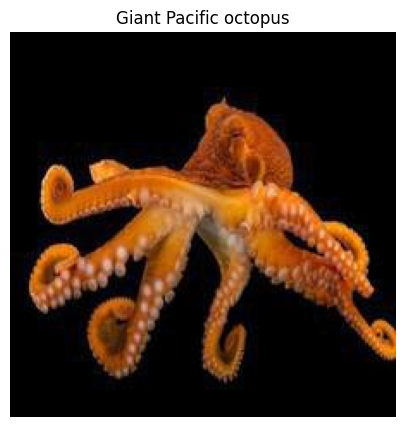

In [10]:
plot_random_image()

## Load image dataset

In [11]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [12]:
DATA_DIR = '/content/animals141/dataset/dataset'

(train_data, test_data) = image_dataset_from_directory(DATA_DIR,
                                                       batch_size=None,
                                                       image_size=(224,224),
                                                       label_mode='categorical',
                                                       seed=42,
                                                       validation_split=0.2,
                                                       subset='both')

Found 6270 files belonging to 151 classes.
Using 5016 files for training.
Using 1254 files for validation.


## Setting mixed precision policy

In [13]:
import tensorflow as tf

In [14]:
print(f'Mixed precision before:{tf.keras.mixed_precision.global_policy()}')

Mixed precision before:<Policy "float32">


In [15]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [16]:
print(f'Mixed precision after:{tf.keras.mixed_precision.global_policy()}')

Mixed precision after:<Policy "mixed_float16">


## Preprocessing images

In [17]:
def preprocess_images(img, label):
  img = img/255.
  return tf.cast(img,tf.float32), label

In [18]:
train_data = train_data.map(map_func=preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(map_func=preprocess_images, num_parallel_calls=tf.data.AUTOTUNE)


          Image shape:(224, 224, 3)
          Image datatype:<dtype: 'float32'>
          Image Max value:0.9215686321258545
          Image Min Value:0.0
  


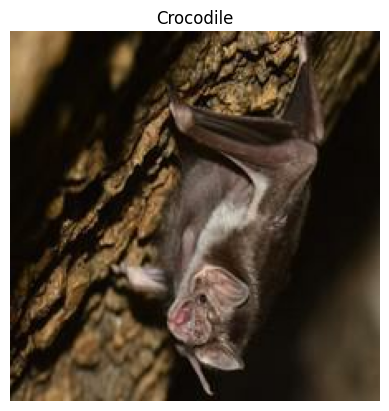

In [19]:
class_names = os.listdir('/content/animals141/dataset/dataset')
for img, label in train_data.take(1):
  print(f"""
          Image shape:{img.shape}
          Image datatype:{img.dtype}
          Image Max value:{tf.reduce_max(img)}
          Image Min Value:{tf.reduce_min(img)}
  """)
  plt.title(class_names[np.array(tf.argmax(label))])
  plt.imshow(img)
  plt.axis(False)

## Creation of the datasets

In [20]:
train_dataset = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 151), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 151), dtype=tf.float32, name=None))>)

## Training a big model with transfer learning

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [23]:
base_model = tf.keras.applications.resnet_v2.ResNet152V2(include_top=False)
base_model.trainable=False #Freezing model layers(patterns learned)

In [24]:
# Setting up model architecture with trainable top layer
inputs = layers.Input(shape=(224,224,3), dtype=tf.float16, name='input_layer')

# set base model to inference model
x = base_model(inputs, training=False)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(len(class_names))(x)

outputs = layers.Activation('softmax', dtype=tf.float32)(x)

model_0 = tf.keras.Model(inputs, outputs)

In [25]:
#compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [26]:
#model summary
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, None, None, 2048   58331648  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 151)               309399    
                                                                 
 activation (Activation)     (None, 151)               0         
                                                                 
Total params: 58641047 (223.70 MB)
Trainable params: 309399 (

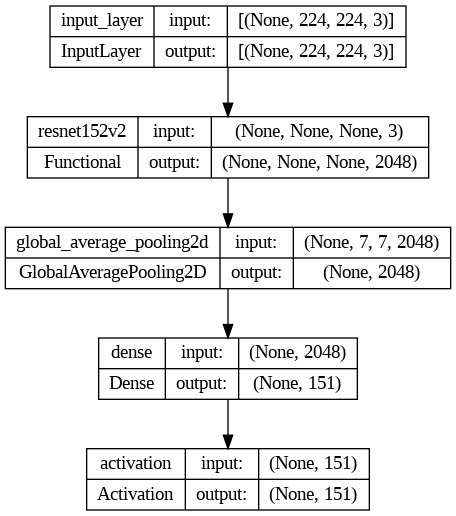

In [27]:
# plotting model
from keras.utils import plot_model
plot_model(model_0, show_shapes=True)

#Fitting model on training data

In [28]:
model_0_history = model_0.fit(train_dataset,
                              epochs=5,
                              steps_per_epoch=len(train_dataset),
                              validation_data=test_dataset,
                              validation_steps=int(0.15*len(test_dataset)))#validates only on 15% of test data

Epoch 1/5
157/157 [==============================] - 39s 122ms/step - loss: 1.7846 - accuracy: 0.6186 - val_loss: 0.6860 - val_accuracy: 0.8281
Epoch 2/5
157/157 [==============================] - 16s 97ms/step - loss: 0.2476 - accuracy: 0.9466 - val_loss: 0.5725 - val_accuracy: 0.8646
Epoch 3/5
157/157 [==============================] - 16s 98ms/step - loss: 0.0965 - accuracy: 0.9904 - val_loss: 0.5475 - val_accuracy: 0.8646
Epoch 4/5
157/157 [==============================] - 16s 100ms/step - loss: 0.0506 - accuracy: 0.9978 - val_loss: 0.5220 - val_accuracy: 0.8750
Epoch 5/5
157/157 [==============================] - 17s 106ms/step - loss: 0.0320 - accuracy: 0.9994 - val_loss: 0.5088 - val_accuracy: 0.8750


## Evaluating model

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

In [30]:
y_pred_probs = model_0.predict(test_dataset)
y_pred = tf.argmax(y_pred_probs, axis=1)

40/40 [==============================] - 7s 104ms/step


In [31]:
y_true=[]
for _, label in test_dataset.unbatch():
  y_true.append(label.numpy().argmax())
y_true=np.array(y_true)

In [32]:
len(y_pred), len(y_true)

(1254, 1254)

In [40]:
print(f'Accuracy:{accuracy_score(y_true, y_pred)*100:.2f}%')

print(classification_report(y_true, y_pred))

Accuracy:88.12%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.20      0.33         5
           2       1.00      0.83      0.91         6
           3       1.00      1.00      1.00        13
           4       0.92      0.92      0.92        12
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         5
           7       1.00      0.88      0.93         8
           8       1.00      1.00      1.00        11
           9       1.00      0.83      0.91         6
          10       1.00      1.00      1.00         8
          11       1.00      0.67      0.80         9
          12       1.00      0.75      0.86         4
          13       1.00      0.67      0.80         6
          14       1.00      0.83      0.91         6
          15       1.00      0.90      0.95        10
          16       1.00      1.00      1.00         7
          1

## Fine-tune

In [41]:
file_path = './animals-151-best_model'
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3,
                                                 min_lr=1e-9)
early_stop = tf.keras.callbacks.EarlyStopping(patience=5)
save_best_model = tf.keras.callbacks.ModelCheckpoint(file_path,
                                                     save_best_only=True,
                                                     save_weights_only=True)

In [42]:
for layer in base_model.layers[-40:]:
  layer.trainable = True #unfreezing layers

In [43]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=Adam(0.0001),
                metrics=['accuracy'])

In [44]:
model_0_history_fine_tune = model_0.fit(train_dataset,epochs=20,
                                        steps_per_epoch=len(train_dataset),
                                        validation_data=test_dataset,
                                        validation_steps=int(0.15*len(test_dataset)),
                                        initial_epoch=model_0_history.epoch[-1],callbacks=[reduce_lr,
                                                                                           early_stop,
                                                                                           save_best_model])

Epoch 5/20
157/157 [==============================] - 33s 131ms/step - loss: 0.0116 - accuracy: 0.9998 - val_loss: 0.5146 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 6/20
157/157 [==============================] - 18s 107ms/step - loss: 0.0095 - accuracy: 0.9998 - val_loss: 0.5145 - val_accuracy: 0.8854 - lr: 1.0000e-04
Epoch 7/20
157/157 [==============================] - 16s 98ms/step - loss: 0.0082 - accuracy: 0.9998 - val_loss: 0.5176 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 8/20
157/157 [==============================] - 16s 100ms/step - loss: 0.0072 - accuracy: 0.9998 - val_loss: 0.5228 - val_accuracy: 0.8854 - lr: 1.0000e-04
Epoch 9/20
157/157 [==============================] - 18s 109ms/step - loss: 0.0061 - accuracy: 0.9998 - val_loss: 0.5204 - val_accuracy: 0.8958 - lr: 1.0000e-05
Epoch 10/20
157/157 [==============================] - 16s 99ms/step - loss: 0.0060 - accuracy: 0.9998 - val_loss: 0.5197 - val_accuracy: 0.8958 - lr: 1.0000e-05
Epoch 11/20
157/157 [========

In [45]:
y_pred_probs = model_0.predict(test_dataset)
y_pred = tf.argmax(y_pred_probs, axis=1)

40/40 [==============================] - 13s 89ms/step


In [46]:
print(f'Accuracy:{accuracy_score(y_true, y_pred):.2f}%')

print(classification_report(y_true, y_pred))

Accuracy:0.89%
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.20      0.33         5
           2       1.00      0.83      0.91         6
           3       1.00      1.00      1.00        13
           4       0.92      0.92      0.92        12
           5       1.00      1.00      1.00         7
           6       1.00      1.00      1.00         5
           7       1.00      0.88      0.93         8
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00         6
          10       1.00      1.00      1.00         8
          11       1.00      0.67      0.80         9
          12       1.00      0.75      0.86         4
          13       1.00      0.50      0.67         6
          14       1.00      0.83      0.91         6
          15       1.00      0.90      0.95        10
          16       1.00      1.00      1.00         7
          17